In [9]:
import pandas as pd

# Read in Data
train_stances = pd.read_csv('train_stances_small.csv')
train_bodies = pd.read_csv('train_bodies_google_pegasus-cnn_dailymail_cleaned.csv')
test_stances = pd.read_csv('competition_test_stances.csv')
test_bodies = pd.read_csv('test_bodies_google_pegasus-cnn_dailymail_cleaned.csv')

In [13]:
from sklearn.model_selection import train_test_split

mapping = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}


# Extract training data
merged = pd.merge(train_stances, train_bodies, on='Body ID')
merged = merged[['Headline', 'articleBody', 'Stance']]
merged['Stance'] = merged['Stance'].map(mapping)

train_df= merged.rename(columns={'Headline':'text_a','articleBody':'text_b','Stance':'labels'})

# Extract testing data
merged = pd.merge(test_stances, test_bodies, on='Body ID')
merged = merged[['Headline', 'articleBody', 'Stance']]
merged['Stance'] = merged['Stance'].map(mapping)

test_df= merged.rename(columns={'Headline':'text_a','articleBody':'text_b','Stance':'labels'})
labels_test = pd.Series(test_df['labels']).to_numpy()

In [15]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from simpletransformers.classification import ClassificationModel

# Set model arguments
model = ClassificationModel('roberta', 'roberta-base', use_cuda=False,num_labels=4, args={
    'learning_rate':1e-5,
    'num_train_epochs': 5,
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'process_count': 10,
    'train_batch_size': 4,
    'eval_batch_size': 4,
    'max_seq_length': 64,
    'fp16': True
})

# Train roberta on our training set
model.train_model(train_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/8340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/2085 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/2085 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/2085 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2085 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2085 [00:00<?, ?it/s]

(10425, 0.43092233065938007)

In [16]:
import numpy as np

# Evaluate model with test set
_, model_outputs_test, _ = model.eval_model(test_df)
preds_test = np.argmax(model_outputs_test, axis=1)

  0%|          | 0/25413 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

In [54]:
from sklearn.metrics import f1_score

# Calculate the macro f1 score
f1_macro = f1_score(labels_test, preds_test, average='macro')

# Calculate the classwise f1 scores for each label
f1_classwise = f1_score(labels_test, preds_test, average=None, labels=[0, 1, 2, 3])

# Nice formatting 
res = "F1 macro: {:.3f}".format(f1_macro * 100) + "%\n"
res += "F1 agree: {:.3f}".format(f1_classwise[0] * 100) + "%\n"
res += "F1 disagree: {:.3f}".format(f1_classwise[1] * 100) + "%\n"
res += "F1 discuss: {:.3f}".format(f1_classwise[2] * 100) + "%\n"
res += "F1 unrelated: {:.3f}".format(f1_classwise[3] * 100) + "%\n"

print(res)

F1 macro: 68.955%
F1 agree: 59.361%
F1 disagree: 41.296%
F1 discuss: 77.016%
F1 unrelated: 98.148%



FNC Score: 74.596% 

ACCURACY: 89.730%


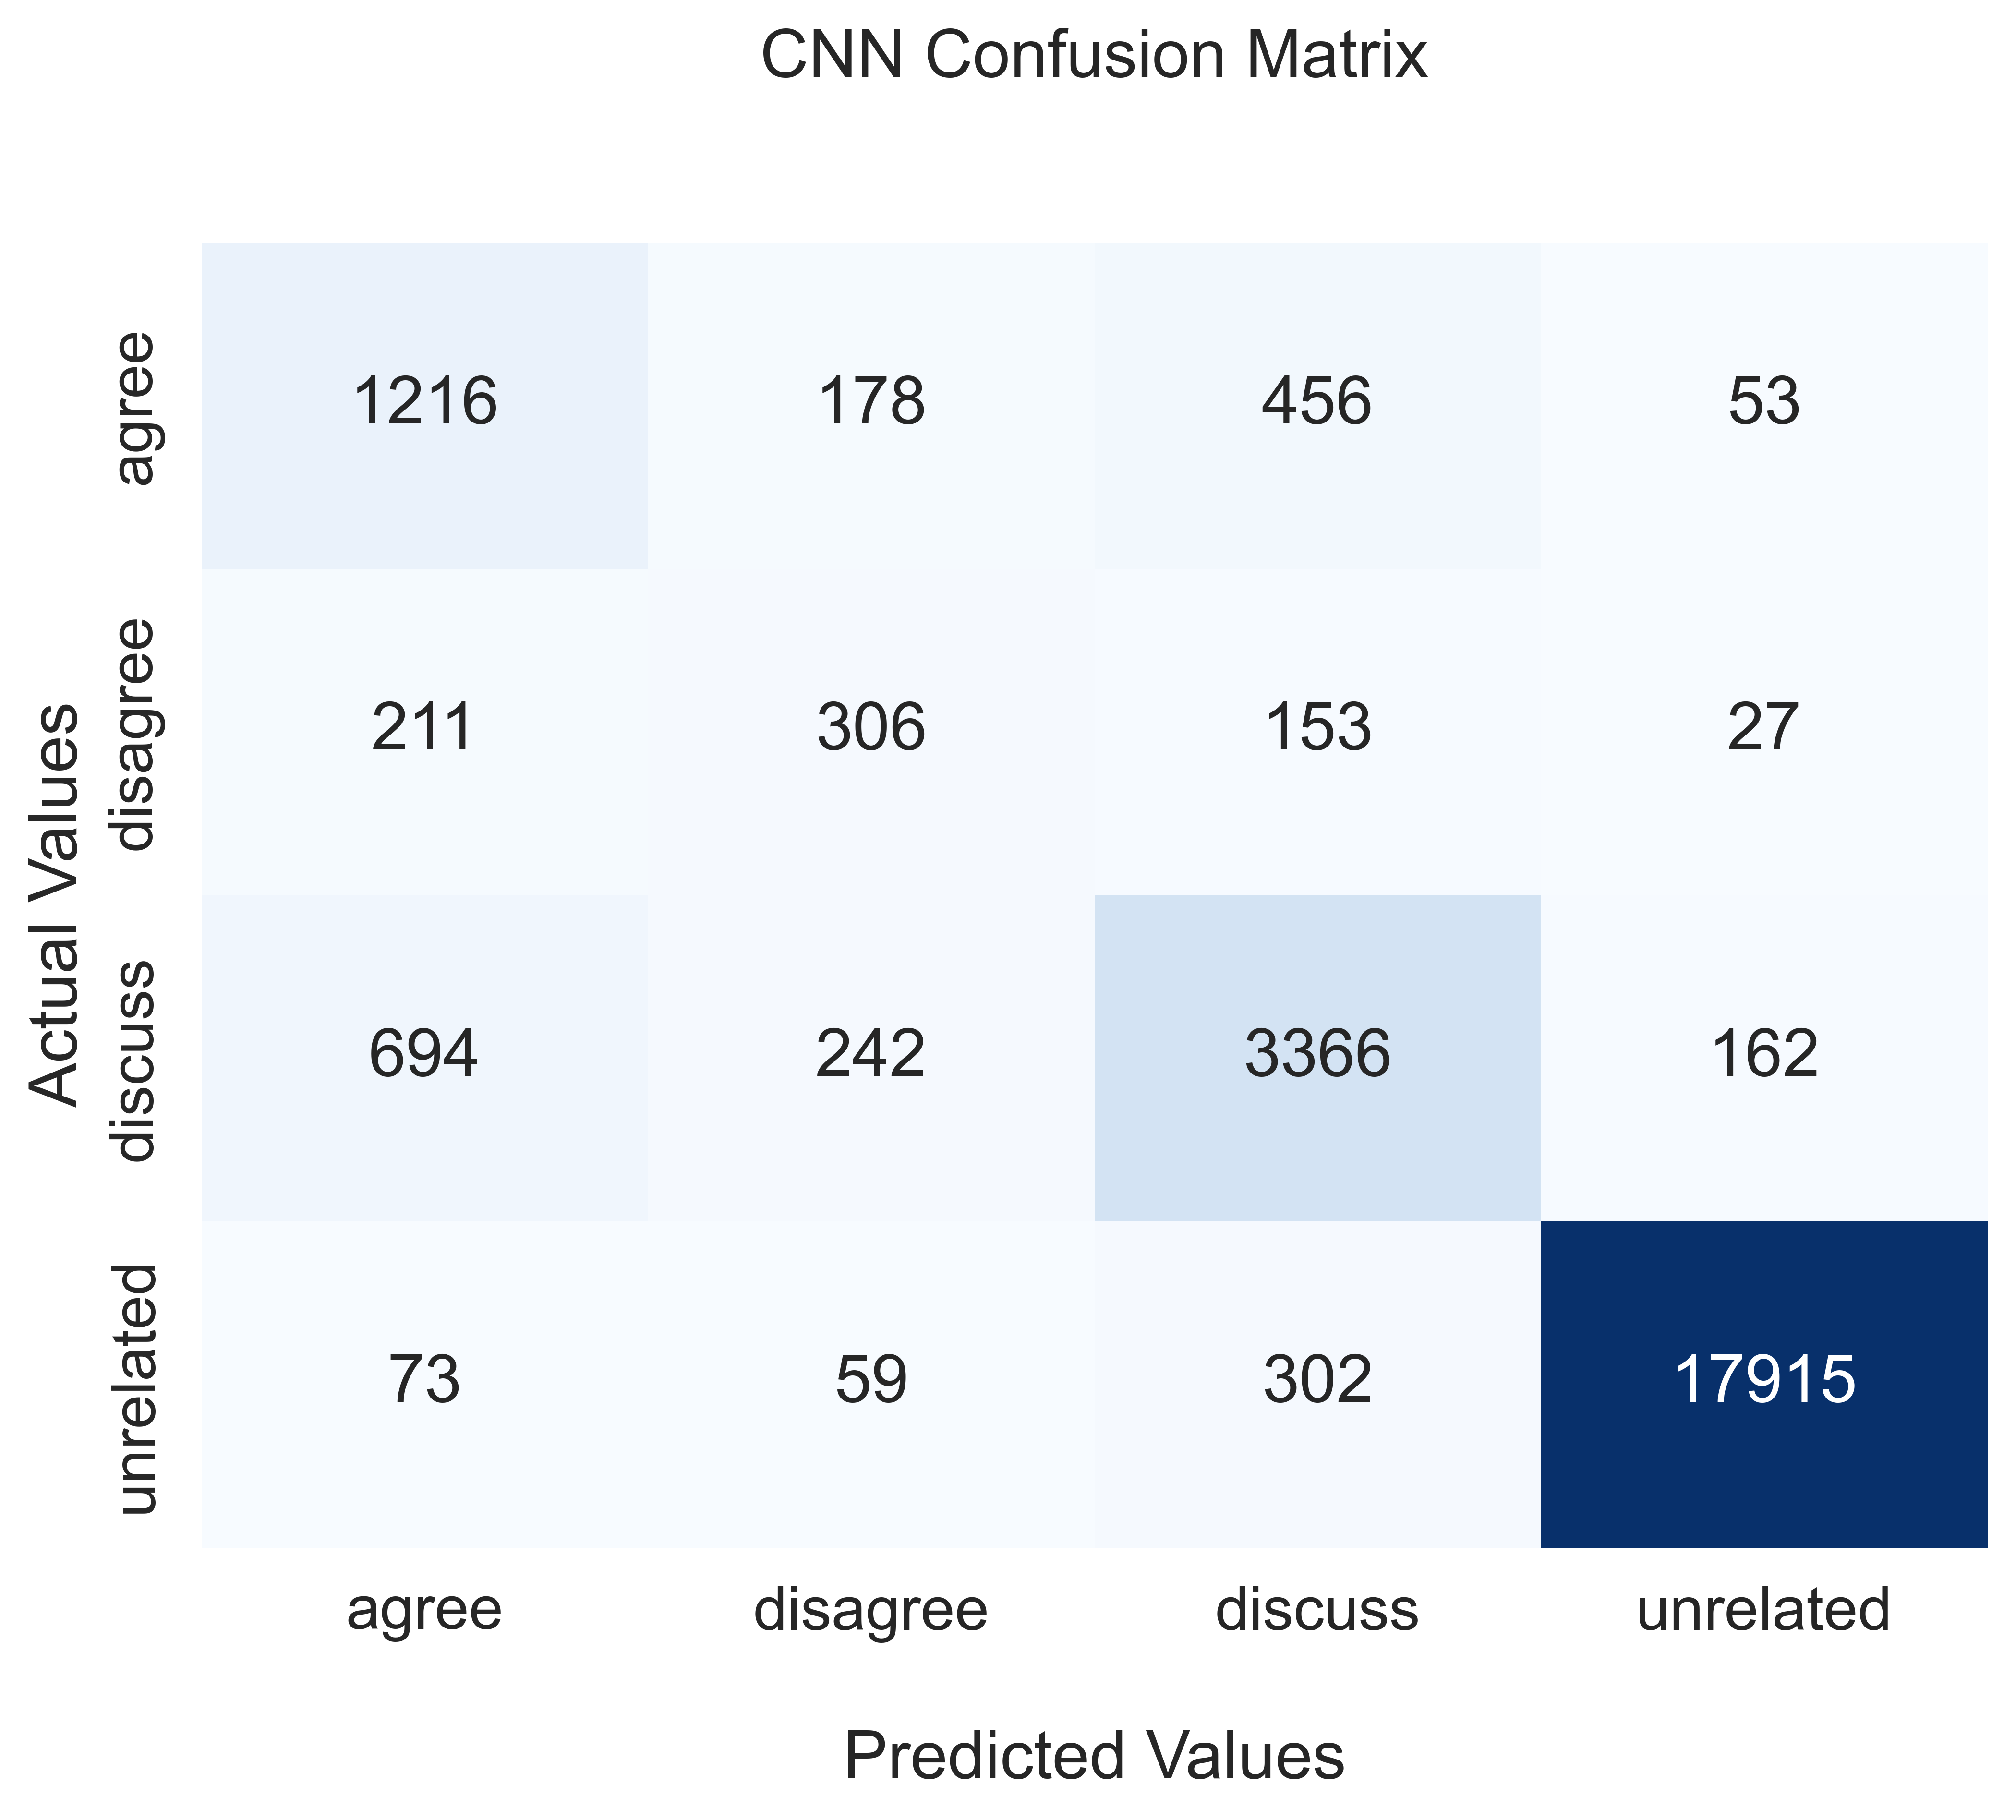

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Labels in numeric and string formats
LABELS = [0, 1, 2, 3]
LABELSTEXT = ['agree', 'disagree', 'discuss', 'unrelated']

# Labels that should get higher FNC score if correctly predicted as related
RELATED = [0, 1, 2]

# Calculate accuracy from confusion matrix
def accuracy_score(cm):
    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
    print("ACCURACY: {:.3f}".format((hit / total)*100) + "%")
   
# Calculate FNC score 
def fnc_score_cm(predicted_labels, target):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]
    for i, (g, t) in enumerate(zip(target, predicted_labels)):
            if g == t:
                score += 0.25
                if g != 3:
                    score += 0.50
            if g in RELATED and t in RELATED:
                score += 0.25

            cm[g][t] += 1
    return score,  cm

# Confusion matrix and FNC-1 score
fnc_score, cm_test = fnc_score_cm(preds_test, labels_test)
print("FNC Score: {:.3f}".format(100/13204.75*fnc_score) + "% \n")

# Retrieve accuracy score from confusion matrix
accuracy_score(cm_test)

# Plot heatmap of confusion matrix
plt.figure(figsize = (8,6),dpi = 600)

sns.set(font_scale=1.4)
ax = sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g',cbar=False,)
ax.set_title('CNN Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(LABELSTEXT)
ax.yaxis.set_ticklabels(LABELSTEXT)

plt.show()

